In [9]:
from datetime import datetime
from pathlib import Path
from typing import TypedDict

import chardet
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from bs4 import BeautifulSoup
from meteostat import Daily, Point
from numpy.lib.stride_tricks import sliding_window_view
from scipy.fft import fft
from scipy.stats import entropy

In [4]:
dataset_path = Path.cwd().parents[1] / "datasets/csv"

In [5]:
# Read and concatenate CSV files
df = pd.concat(
    [
        pd.read_csv(dataset_path/"washingtondc.csv"),
        pd.read_csv(dataset_path/"liestal.csv"),
        pd.read_csv(dataset_path/"kyoto.csv"),
        pd.read_csv(dataset_path/"vancouver.csv"),
        pd.read_csv(dataset_path/"south_korea.csv"),
        pd.read_csv(dataset_path/"japan.csv"),
        pd.read_csv(dataset_path/"nyc.csv"),
        pd.read_csv(dataset_path/"meteoswiss.csv", encoding="ISO-8859-1"),
    ],
    ignore_index=True,
)

In [6]:
# Function to split location 
def split_location(location): 
    parts = location.split('/', 1) 
    if len(parts) == 2: return parts 
    else: return [None, location]
    
# Apply the function to the location column 
df[['country', 'city']] = df['location'].apply(split_location).apply(pd.Series)

In [3]:
df_weather_data = pd.read_csv("all_dates.csv")
df_weather_data.head(1)

,Unnamed: 0,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,day_of_year,city
0,0,2023-01-01,11.8,5.6,16.7,0.0,0.0,205.0,7.9,NaN,1015.6,NaN,1,washingtondc


In [7]:
# Perform a left join based on 'city' and 'time' (full date)
merged_df = pd.merge(
    df_weather_data,
    df,
    left_on=["city", "time"],
    right_on=["city", "bloom_date"],
    how="left",
    suffixes=("_temp", "_bloom"),
)

merged_df["time"] = pd.to_datetime(merged_df["time"])

In [11]:
# For sample entropy, we can define a simple implementation:
def sample_entropy(time_series, m=2, r=None):
    """
    Calculate the sample entropy of a time series.

    Args:
        time_series (array-like): The time series data.
        m (int): The length of sequences to compare.
        r (float): Tolerance (if None, use 0.2 * std(time_series)).

    Returns:
        float: The sample entropy.
    """
    time_series = np.array(time_series, dtype=float)
    N = len(time_series)
    if r is None:
        r = 0.2 * np.std(time_series)

    def _phi(m):
        # Build sliding windows of size m
        X = sliding_window_view(time_series, window_shape=m)
        count = 0
        total = 0
        for i in range(len(X)):
            template = X[i]
            # Compare to all subsequent windows (to avoid self-matches)
            for j in range(i + 1, len(X)):
                dist = np.max(np.abs(template - X[j]))
                if dist < r:
                    count += 1
                total += 1
        return count / total if total > 0 else 0

    phi_m = _phi(m)
    phi_m1 = _phi(m + 1)

    # Avoid division by zero:
    if phi_m == 0 or phi_m1 == 0:
        return np.inf
    return -np.log(phi_m1 / phi_m)

In [12]:
# PARAMETERS
base_temp = 10.0  # Base temperature for GDD calculation (°C)
rolling_window_size = 7  # in days

# Make sure 'time' is datetime and extract year
merged_df["time"] = pd.to_datetime(merged_df["time"])
merged_df["temp_year"] = merged_df["time"].dt.year

# Optionally, if tavg is missing, compute it:
if "tavg" not in merged_df.columns or merged_df["tavg"].isna().all():
    merged_df["tavg"] = (merged_df["tmin"] + merged_df["tmax"]) / 2

In [15]:
# Function to compute daily GDD using the formula:
# GDD = max( ((tmax + tmin)/2 - base_temp), 0)
def compute_daily_gdd(row, base=base_temp):
    avg_temp = (row["tmax"] + row["tmin"]) / 2
    return max(avg_temp - base, 0)


# Compute daily GDD for every row in merged_df
merged_df["daily_gdd"] = merged_df.apply(compute_daily_gdd, axis=1)

In [ ]:
# Compute cumulative GDD up to bloom for each city-year.
# We assume that bloom_doy is available for each city-year.
cumulative_gdd_records = []

# Group by city and year:
for (city, year), group in merged_df.groupby(["city", "temp_year"]):
    # Ensure the group is sorted by day_of_year
    group = group.sort_values(by="day_of_year")

    # Check if bloom_doy exists (take the first non-null value)
    if group["bloom_doy"].notna().any():
        bloom_doy = group["bloom_doy"].dropna().iloc[0]
        # Filter data up to (and including) the bloom day:
        valid_days = group[group["day_of_year"] <= bloom_doy]
        cumulative_gdd = valid_days["daily_gdd"].sum()
        cumulative_gdd_records.append(
            {
                "city": city,
                "year": year,
                "bloom_doy": bloom_doy,
                "cumulative_gdd": cumulative_gdd,
            }
        )

# Create a DataFrame with cumulative GDD information:
gdd_df = pd.DataFrame(cumulative_gdd_records)
print("Cumulative GDD per city-year:")
gdd_df.head()

Cumulative GDD per city-year:


,city,year,bloom_doy,cumulative_gdd
0,Adelboden,2023,125.0,9.05
1,Alchenflüh,2023,110.0,9.25
2,Altdorf,2023,97.0,17.65
3,Appenzell,2023,119.0,22.70
4,Azmoos,2023,108.0,0.90


In [24]:
# Now, let us perform a rolling window feature extraction on the daily tavg values.
# We will compute several features for each window in each city-year group.
# The features will include:
#   - Time Domain: mean, std, min, max
#   - Frequency Domain: dominant frequency amplitude (using FFT)
#   - Non-linear Domain: sample entropy
rolling_feature_records = []


def extract_fft_feature(window_data):
    # Compute FFT and take the amplitude of the dominant (non-DC) frequency
    fft_vals = fft(window_data)
    # Exclude the zero frequency component
    fft_vals = np.abs(fft_vals[1:])
    if len(fft_vals) > 0:
        dominant_amp = np.max(fft_vals)
    else:
        dominant_amp = 0
    return dominant_amp


# Loop over each city-year group
for (city, year), group in merged_df.groupby(["city", "temp_year"]):
    group = group.sort_values(by="day_of_year")
    # We only consider days up to bloom day, if available
    if group["bloom_doy"].notna().any():
        bloom_doy = group["bloom_doy"].dropna().iloc[0]
        valid_group = group[group["day_of_year"] <= bloom_doy]
    else:
        valid_group = group

    # Make sure we have enough data for a rolling window:
    if len(valid_group) < rolling_window_size:
        continue

    # Use the 'tavg' column as the time series.
    temp_series = valid_group["tavg"].values
    days = valid_group["day_of_year"].values

    # Compute rolling windows. We use a simple sliding window approach.
    for i in range(len(temp_series) - rolling_window_size + 1):
        window_data = temp_series[i : i + rolling_window_size]
        window_days = days[i : i + rolling_window_size]
        # Compute features
        time_mean = np.mean(window_data)
        time_std = np.std(window_data)
        time_min = np.min(window_data)
        time_max = np.max(window_data)
        dominant_fft_amp = extract_fft_feature(window_data)
        samp_entropy = sample_entropy(window_data)

        # Record the window's starting day and ending day (or center day)
        center_day = window_days[rolling_window_size // 2]

        rolling_feature_records.append(
            {
                "city": city,
                "year": year,
                "window_start": window_days[0],
                "window_end": window_days[-1],
                "center_day": center_day,
                "mean_temp": time_mean,
                "std_temp": time_std,
                "min_temp": time_min,
                "max_temp": time_max,
                "dominant_fft_amp": dominant_fft_amp,
                "sample_entropy": samp_entropy,
            }
        )

# Create a DataFrame with rolling window features:
rolling_features_df = pd.DataFrame(rolling_feature_records)
print("Rolling window features sample:")
rolling_features_df.head()

Rolling window features sample:


,city,year,window_start,window_end,center_day,mean_temp,std_temp,min_temp,max_temp,dominant_fft_amp,sample_entropy
0,Abashiri,2023,1,7,4,-9.214286,2.937165,-14.0,-5.5,13.524448,inf
1,Abashiri,2023,2,8,5,-9.828571,2.611357,-14.0,-5.5,12.105342,inf
2,Abashiri,2023,3,9,6,-9.457143,2.673605,-14.0,-5.5,10.562070,inf
3,Abashiri,2023,4,10,7,-8.285714,2.176779,-12.0,-5.5,10.001648,inf
4,Abashiri,2023,5,11,8,-7.414286,1.679650,-10.2,-5.5,6.706636,inf


In [27]:
gdd_df["city"].unique()

array(['Adelboden', 'Alchenflüh ', 'Altdorf', 'Appenzell', 'Azmoos',
       'Basel-Binningen', 'Bauma', 'Bellelay', 'Biel', 'Birmensdorf',
       'Blonay', 'Boudry', 'Brusio-Piazzo', 'Buchs', 'Cartigny',
       'Changins', 'Chaumont', 'Chur', 'Comprovasco / Motto', 'Couvet',
       'Davos-Dorf', 'Diessenhofen', 'Disentis', 'Domat / Ems', 'Dornach',
       'Döttingen', 'Echandens', 'Edlibach', 'Elm', 'Enges', 'Entlebuch',
       'Escholzmatt', 'Estavayer-le-Lac', 'Fiesch', 'Flawil',
       'Frauenfeld', 'Gadmen', 'Grüsch', 'Hallau', 'Hard b. Weinfelden',
       'Heiden', 'Herzogenbuchsee', 'Hochdorf', 'Horgen', 'Höfen',
       'Jegenstorf II', 'Jenaz', 'Kandersteg', "L'Abergement",
       'La Brévine', 'La Valsainte', 'Langnau i.E.', 'Laufenburg',
       'Le Locle', 'Les Ponts-de-Martel', 'Les Rangiers', 'Leysin',
       'Liestal', 'Linthal', 'Locarno', 'Locarno-Monti', 'Longirod',
       'Luzern', 'Martina', 'Mellingen', 'Merishausen', 'Moutier',
       'Mugena', 'Murg', 'Muri, AG', 'N

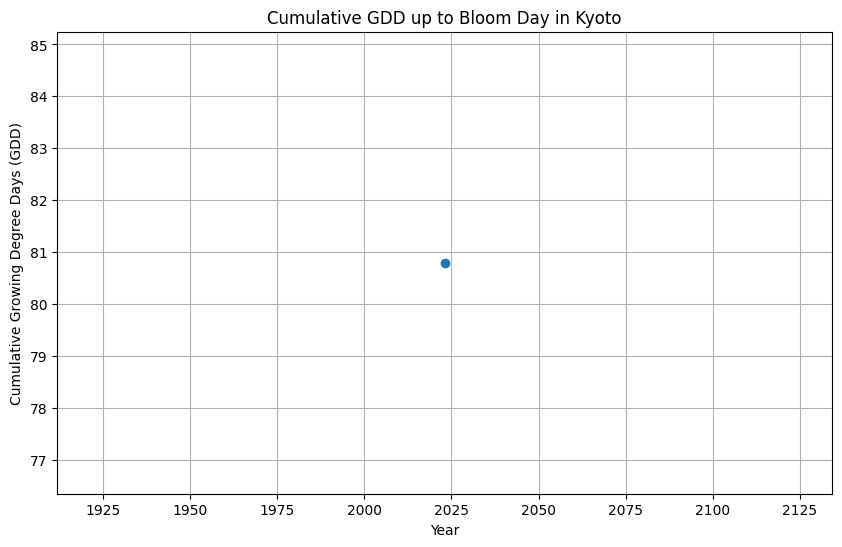

In [28]:
# You now have two tabular datasets:
# 1. gdd_df: cumulative GDD (up to bloom day) for each city-year.
# 2. rolling_features_df: features computed from a rolling window on the temperature series.
#
# For illustration, let’s plot the cumulative GDD (y-axis) vs. year (x-axis) for a selected city.
# You could also merge these data if you wish to see correlations between the rolling features and GDD.

# Example: Plot cumulative GDD over time for a specific city (say, the first city in gdd_df)
if not gdd_df.empty:
    selected_city = "kyoto" #gdd_df["city"].iloc[0]
    city_gdd = gdd_df[gdd_df["city"] == selected_city].sort_values(by="year")

    plt.figure(figsize=(10, 6))
    plt.plot(city_gdd["year"], city_gdd["cumulative_gdd"], marker="o", linestyle="-")
    plt.xlabel("Year")
    plt.ylabel("Cumulative Growing Degree Days (GDD)")
    plt.title(f"Cumulative GDD up to Bloom Day in {selected_city.capitalize()}")
    plt.grid(True)
    plt.show()

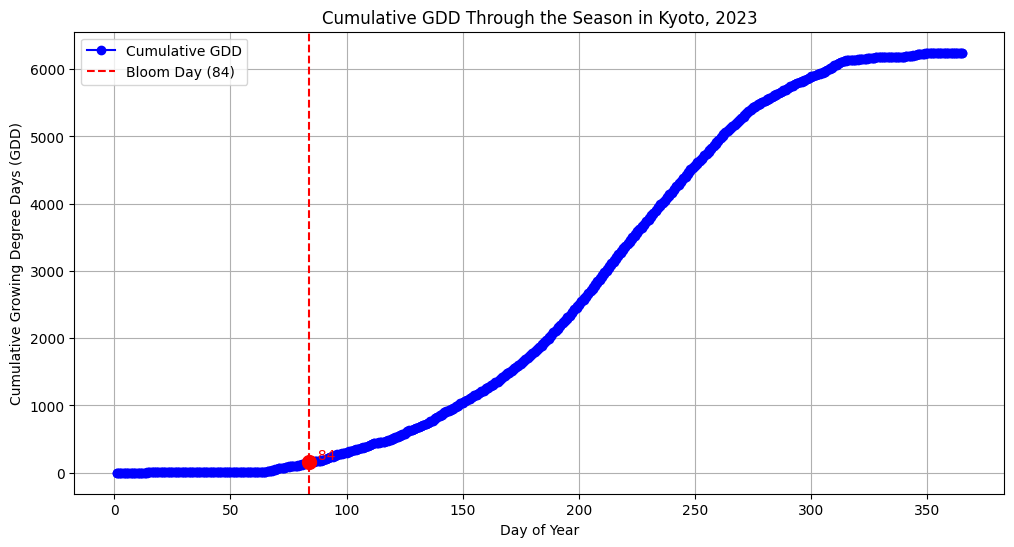

In [36]:
# Example: Using the merged_df DataFrame from the previous code.
# Make sure that merged_df has:
#   - a 'time' column (datetime)
#   - a 'daily_gdd' column computed
#   - a 'day_of_year' column (which can be extracted from 'time')
#   - a 'bloom_doy' column containing the bloom day of year (if available)
#   - a 'city' column and a 'temp_year' column

# Filter for a single city and a single year.
selected_city = "kyoto"
selected_year = 2023

# Ensure that the 'time' column is a datetime type and that day_of_year is present.
merged_df['time'] = pd.to_datetime(merged_df['time'])
if 'day_of_year' not in merged_df.columns:
    merged_df['day_of_year'] = merged_df['time'].dt.dayofyear

# Filter the data for the selected city and year.
df_single = merged_df[(merged_df['city'].str.lower() == selected_city.lower()) & 
                      (merged_df['temp_year'] == selected_year)].copy()

# Sort the data by day_of_year
df_single.sort_values('day_of_year', inplace=True)

# Calculate the cumulative GDD for each day.
df_single['cumulative_gdd'] = df_single['daily_gdd'].cumsum()

# Get the bloom day, if available.
if df_single['bloom_doy'].notna().any():
    bloom_day = df_single['bloom_doy'].dropna().iloc[0]
else:
    bloom_day = None

# Create the plot.
plt.figure(figsize=(12, 6))
plt.plot(df_single['day_of_year'], df_single['cumulative_gdd'], 
         marker='o', linestyle='-', color='blue', label='Cumulative GDD')

# If bloom day is known, add a vertical line and a marker.
if bloom_day is not None:
    plt.axvline(bloom_day, color='red', linestyle='--', label=f'Bloom Day ({int(bloom_day)})')
    # Find the cumulative GDD at the bloom day
    bloom_row = df_single[df_single['day_of_year'] == bloom_day]
    if not bloom_row.empty:
        bloom_cum_gdd = bloom_row['cumulative_gdd'].iloc[0]
        plt.scatter(bloom_day, bloom_cum_gdd, color='red', s=100, zorder=5)
        plt.text(bloom_day, bloom_cum_gdd, f'  {int(bloom_day)}', color='red', va='bottom')

plt.xlabel("Day of Year")
plt.ylabel("Cumulative Growing Degree Days (GDD)")
plt.title(f"Cumulative GDD Through the Season in {selected_city.capitalize()}, {selected_year}")
plt.legend()
plt.grid(True)
plt.show()

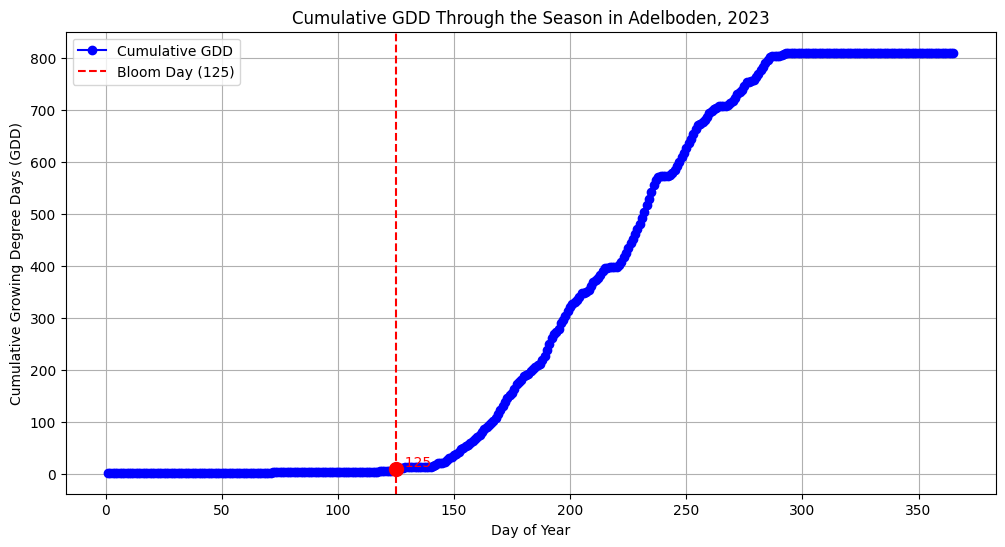

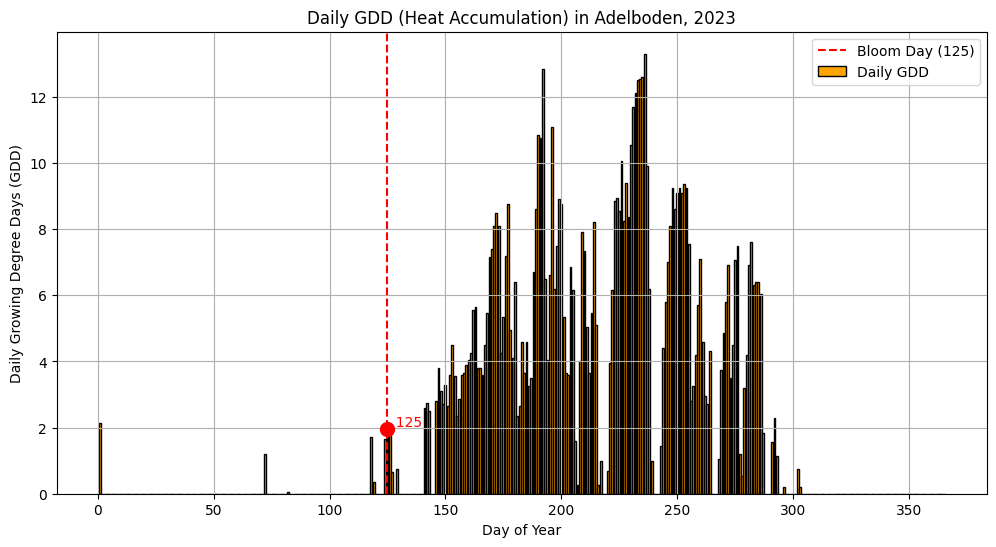

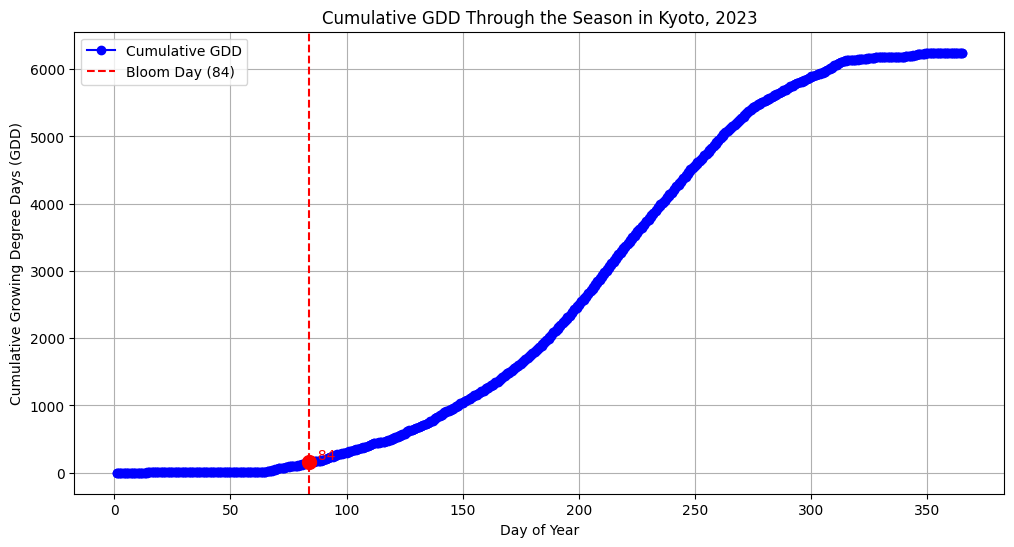

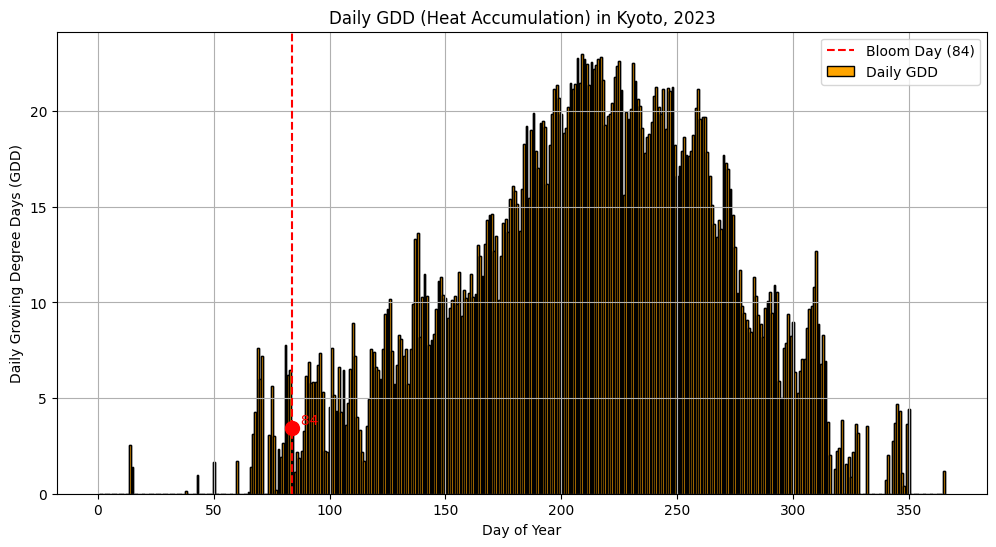

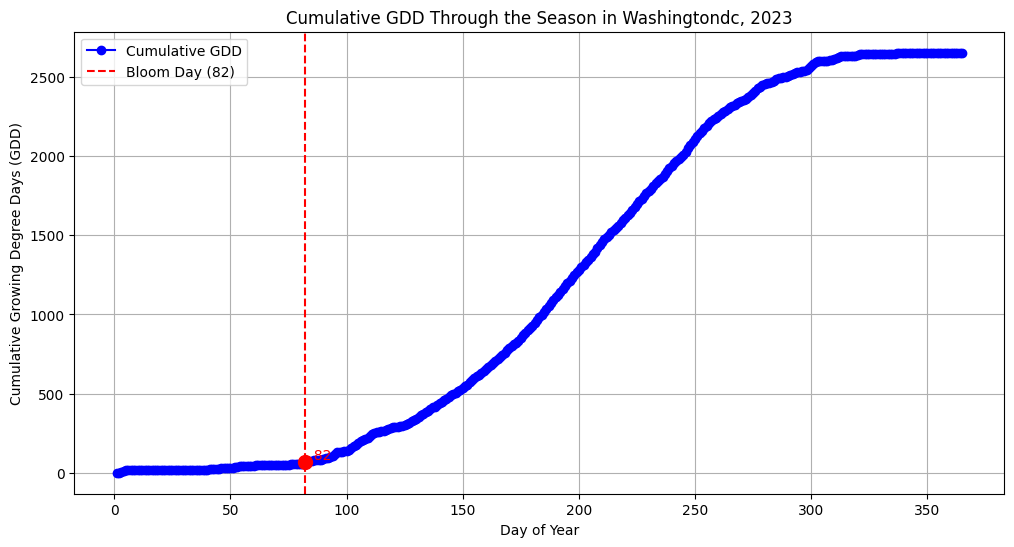

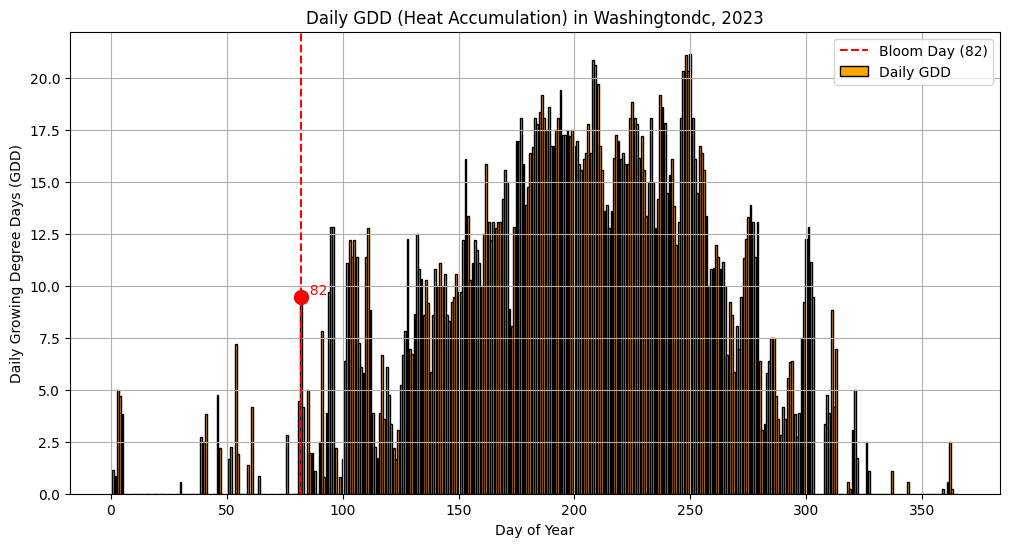

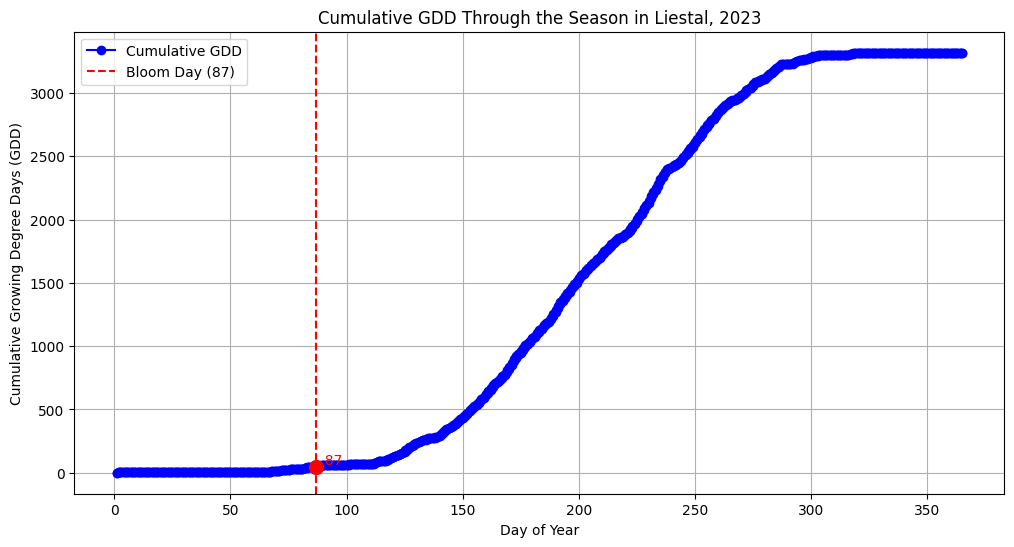

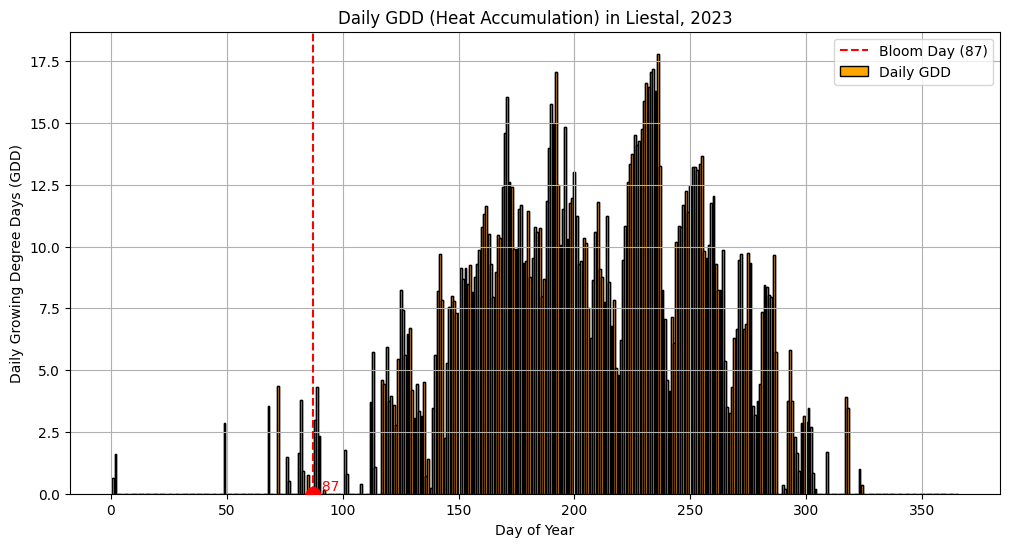

In [42]:
# # --- Parameters and Data Preparation ---
# base_temp = 10.0  # Define the base temperature for GDD

# # Make sure that 'time' is datetime and create day_of_year if needed
# merged_df['time'] = pd.to_datetime(merged_df['time'])
# if 'day_of_year' not in merged_df.columns:
#     merged_df['day_of_year'] = merged_df['time'].dt.dayofyear

# # If daily_gdd is not already computed, calculate it:
# def compute_daily_gdd(row, base=base_temp):
#     avg_temp = (row['tmax'] + row['tmin']) / 2
#     return max(avg_temp - base, 0)

# if 'daily_gdd' not in merged_df.columns:
#     merged_df['daily_gdd'] = merged_df.apply(compute_daily_gdd, axis=1)

# Select a city and a year for the analysis:
selected_city = "kyoto"
selected_year = 2023

for selected_city in ["Adelboden", "kyoto", "washingtondc", "liestal"]:
    # Filter the data for the selected city and year.
    df_single = merged_df[(merged_df['city'].str.lower() == selected_city.lower()) &
                        (merged_df['temp_year'] == selected_year)].copy()

    # Sort the data by day_of_year to ensure chronological order.
    df_single.sort_values('day_of_year', inplace=True)

    # --- Plot 1: Cumulative GDD vs. Day-of-Year ---

    # Calculate the cumulative GDD up to each day.
    df_single['cumulative_gdd'] = df_single['daily_gdd'].cumsum()

    # Get the bloom day, if available.
    if df_single['bloom_doy'].notna().any():
        bloom_day = int(df_single['bloom_doy'].dropna().iloc[0])
    else:
        bloom_day = None

    # Create the cumulative GDD plot.
    plt.figure(figsize=(12, 6))
    plt.plot(df_single['day_of_year'], df_single['cumulative_gdd'], marker='o', linestyle='-', color='blue', label='Cumulative GDD')

    # Mark the bloom day if available.
    if bloom_day is not None:
        plt.axvline(bloom_day, color='red', linestyle='--', label=f'Bloom Day ({bloom_day})')
        # Mark the cumulative GDD at bloom
        bloom_row = df_single[df_single['day_of_year'] == bloom_day]
        if not bloom_row.empty:
            bloom_cum_gdd = bloom_row['cumulative_gdd'].iloc[0]
            plt.scatter(bloom_day, bloom_cum_gdd, color='red', s=100, zorder=5)
            plt.text(bloom_day, bloom_cum_gdd, f'  {bloom_day}', color='red', va='bottom')

    plt.xlabel("Day of Year")
    plt.ylabel("Cumulative Growing Degree Days (GDD)")
    plt.title(f"Cumulative GDD Through the Season in {selected_city.capitalize()}, {selected_year}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Plot 2: Daily (Incremental) GDD vs. Day-of-Year ---
    # This plot shows the daily contribution to the heat accumulation.
    plt.figure(figsize=(12, 6))

    # Create a bar chart for the daily GDD values.
    plt.bar(df_single['day_of_year'], df_single['daily_gdd'], color='orange', edgecolor='black', 
            label='Daily GDD')

    # Mark the bloom day if available.
    if bloom_day is not None:
        plt.axvline(bloom_day, color='red', linestyle='--', label=f'Bloom Day ({bloom_day})')
        # Optionally, you can annotate the bloom day on the plot:
        # Find the daily GDD value at the bloom day (if it exists)
        bloom_row = df_single[df_single['day_of_year'] == bloom_day]
        if not bloom_row.empty:
            daily_gdd_at_bloom = bloom_row['daily_gdd'].iloc[0]
            plt.scatter(bloom_day, daily_gdd_at_bloom, color='red', s=100, zorder=5)
            plt.text(bloom_day, daily_gdd_at_bloom, f'  {bloom_day}', color='red', va='bottom')

    plt.xlabel("Day of Year")
    plt.ylabel("Daily Growing Degree Days (GDD)")
    plt.title(f"Daily GDD (Heat Accumulation) in {selected_city.capitalize()}, {selected_year}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [34]:
rolling_features_df["city"].unique()

array(['Abashiri', 'Adelboden', 'Aikawa', 'Akita', 'Alchenflüh ',
       'Altdorf', 'Andeer', 'Aomori', 'Appenzell', 'Asahikawa',
       'Aurigeno', 'Azmoos', 'Ballens', 'Basel-Binningen', 'Bauma',
       'Bellelay', 'Biel', 'Birmensdorf', 'Blonay', 'Boeun', 'Boryeong',
       'Boudry', 'Brusio-Piazzo', 'Buan', 'Buchs', 'Busan', 'Cartigny',
       'Cernier', 'Cevio-Cavergno', 'Changins', 'Chardonne', 'Chaumont',
       'Cheonan', 'Cheongju', 'Choshi', 'Chuncheon', 'Chungju',
       'Chupungnyeong', 'Chur', 'Comprovasco / Motto', 'Couvet', 'Daegu',
       'Daejeon', 'Davos-Dorf', 'Diessenhofen', 'Disentis', 'Domat / Ems',
       'Dornach', 'Döttingen', 'Echandens', 'Edlibach', 'Einsiedeln',
       'Elm', 'Enges', 'Entlebuch', 'Esashi', 'Eschen-Boja',
       'Escholzmatt', 'Estavayer-le-Lac', 'Faido', 'Fanas', 'Fiesch',
       'Flawil', 'Frauenfeld', 'Fukue', 'Fukui', 'Fukuoka', 'Fukushima',
       'Gadmen', 'Ganghwa', 'Geumsan', 'Gifu', 'Grellingen',
       'Grossdietwil', 'Grüsch', 'Gs

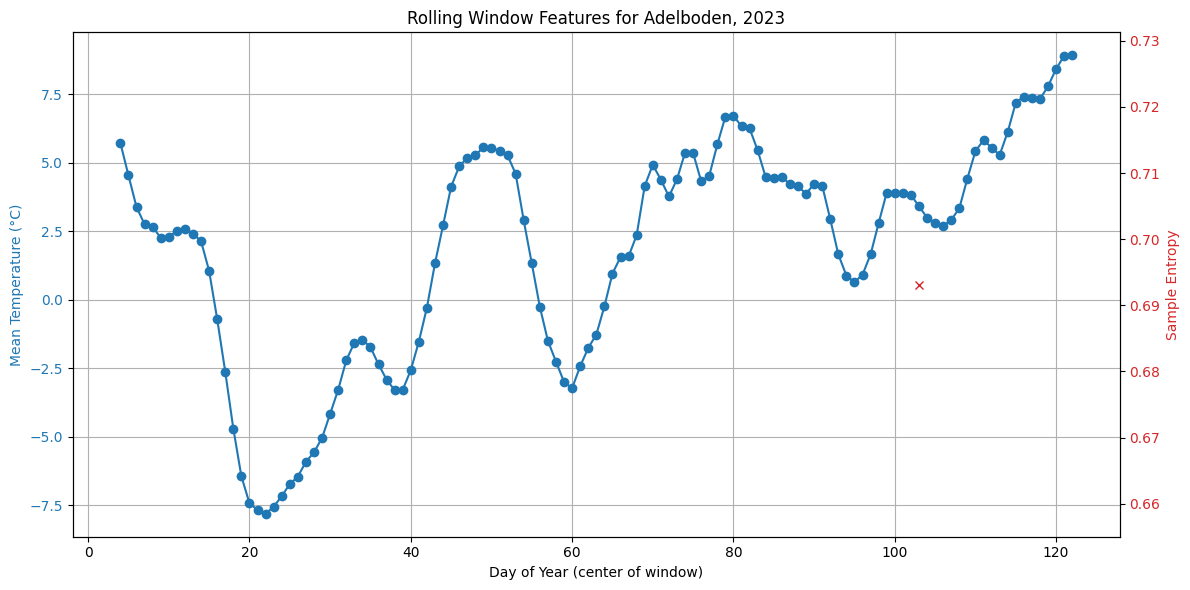

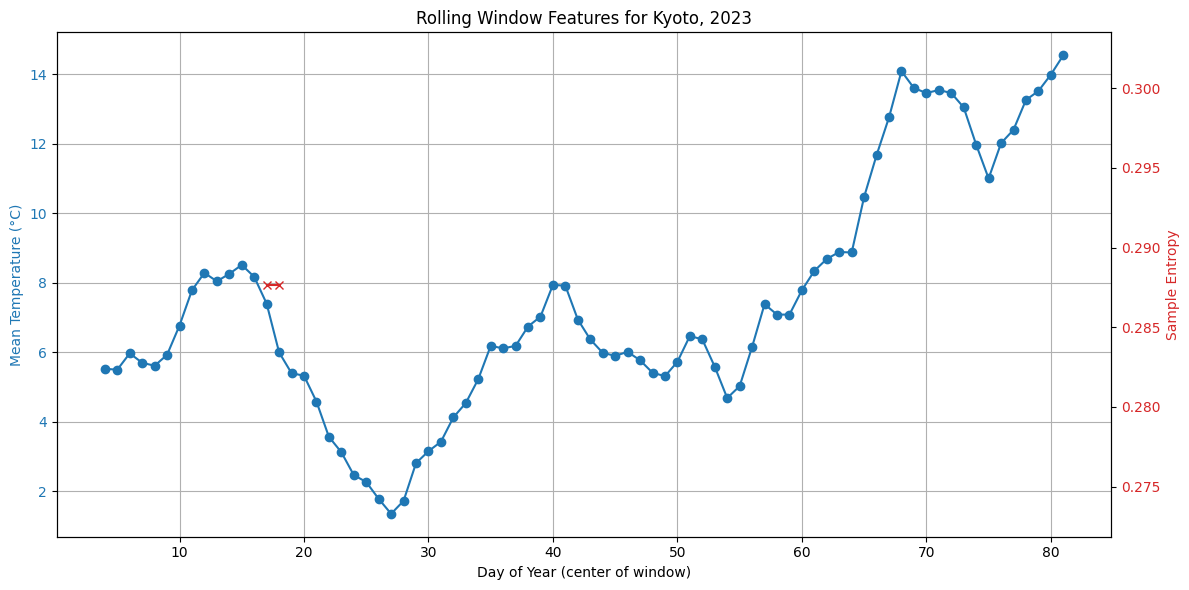

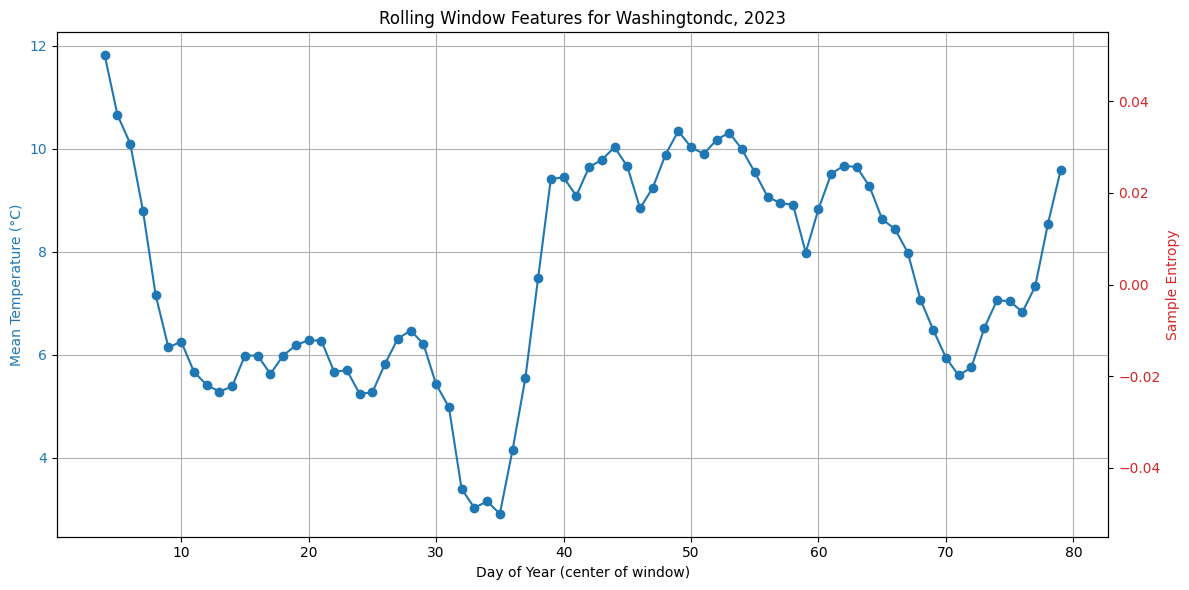

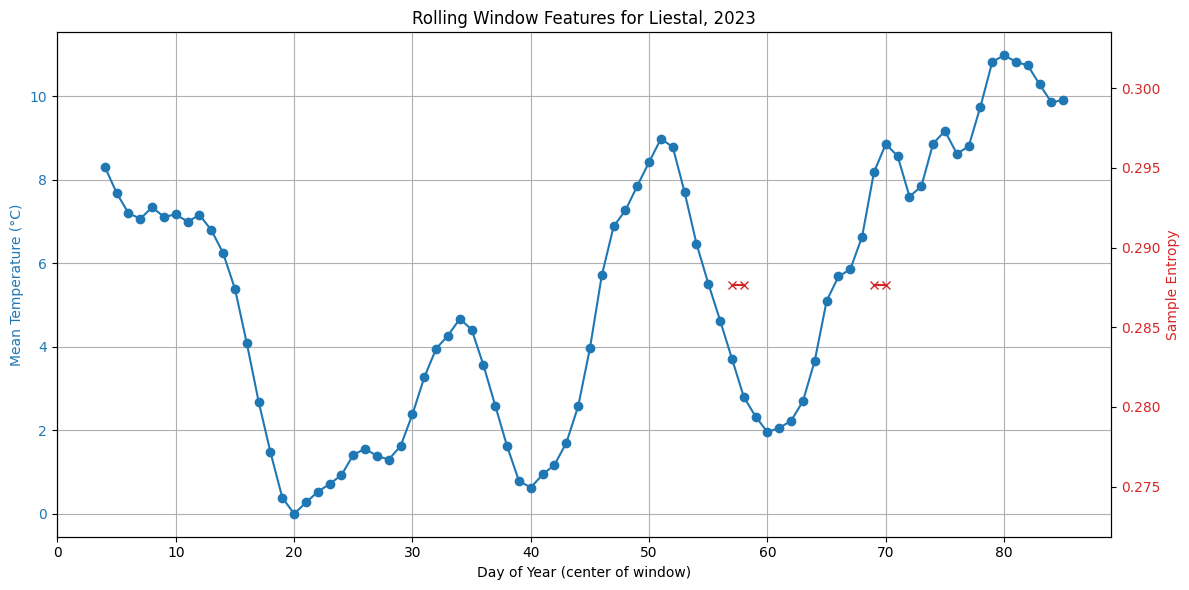

In [43]:
# Additionally, you can explore the rolling window features.
# For example, plot the mean temperature and sample entropy over the days (relative to bloom) for a given year.
# Here we choose one city and one year:
if not rolling_features_df.empty:
    for sample_city in ["Adelboden", "kyoto", "washingtondc", "liestal"]: #rolling_features_df["city"].unique():
        #sample_city = rolling_features_df["city"].iloc[0]
        sample_year = rolling_features_df[rolling_features_df["city"] == sample_city][
            "year"
        ].iloc[0]
        sample_features = rolling_features_df[
            (rolling_features_df["city"] == sample_city)
            & (rolling_features_df["year"] == sample_year)
        ]

        fig, ax1 = plt.subplots(figsize=(12, 6))

        color = "tab:blue"
        ax1.set_xlabel("Day of Year (center of window)")
        ax1.set_ylabel("Mean Temperature (°C)", color=color)
        ax1.plot(
            sample_features["center_day"],
            sample_features["mean_temp"],
            color=color,
            marker="o",
            label="Mean Temp",
        )
        ax1.tick_params(axis="y", labelcolor=color)
        ax1.grid(True)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = "tab:red"
        ax2.set_ylabel("Sample Entropy", color=color)
        ax2.plot(
            sample_features["center_day"],
            sample_features["sample_entropy"],
            color=color,
            marker="x",
            label="Sample Entropy",
        )
        ax2.tick_params(axis="y", labelcolor=color)

        plt.title(
            f"Rolling Window Features for {sample_city.capitalize()}, {sample_year}"
        )
        fig.tight_layout()
        plt.show()

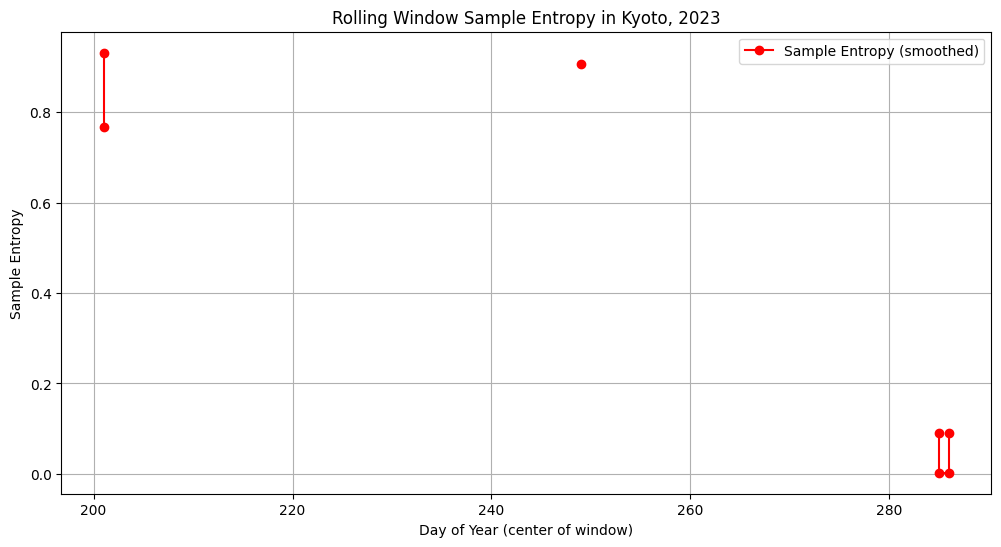

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from scipy.signal import savgol_filter

def sample_entropy(time_series, m=2, r=None):
    """Calculate the sample entropy of a time series."""
    time_series = np.array(time_series, dtype=float)
    N = len(time_series)
    if N < m + 1:
        return np.nan  # Not enough data to compute entropy
    if r is None:
        r = 0.2 * np.std(time_series)
    
    def _phi(m):
        X = sliding_window_view(time_series, window_shape=m)
        count = 0
        total = 0
        for i in range(len(X)):
            template = X[i]
            for j in range(i+1, len(X)):
                if np.max(np.abs(template - X[j])) < r:
                    count += 1
                total += 1
        return count / total if total > 0 else np.nan

    phi_m = _phi(m)
    phi_m1 = _phi(m + 1)
    if phi_m == 0 or phi_m1 == 0 or np.isnan(phi_m) or np.isnan(phi_m1):
        return np.nan
    return -np.log(phi_m1 / phi_m)

# Example: Extract rolling sample entropy for one city and one year:
selected_city = "kyoto"
selected_year = 2023

# Filter for a single city and year.
df_single = merged_df[(merged_df['city'].str.lower() == selected_city.lower()) &
                      (merged_df['temp_year'] == selected_year)].copy()
df_single.sort_values('day_of_year', inplace=True)

# Parameters for rolling window and sample entropy calculation.
rolling_window_size = 7
m = 2
r_factor = 0.2  # r will be set as r_factor * std(window_data)

entropy_values = []
center_days = []

temp_series = df_single['tavg'].values
days = df_single['day_of_year'].values

for i in range(len(temp_series) - rolling_window_size + 1):
    window_data = temp_series[i:i+rolling_window_size]
    window_day = days[i + rolling_window_size // 2]
    r = r_factor * np.std(window_data)
    ent = sample_entropy(window_data, m=m, r=r)
    entropy_values.append(ent)
    center_days.append(window_day)

# Optionally smooth the entropy values using a Savitzky-Golay filter:
entropy_values = np.array(entropy_values)
if len(entropy_values) > 5:  # Only smooth if there are enough points
    entropy_smoothed = savgol_filter(entropy_values, window_length=5, polyorder=2)
else:
    entropy_smoothed = entropy_values

plt.figure(figsize=(12, 6))
plt.plot(center_days, entropy_smoothed, marker='o', linestyle='-', color='red', label='Sample Entropy (smoothed)')
plt.xlabel("Day of Year (center of window)")
plt.ylabel("Sample Entropy")
plt.title(f"Rolling Window Sample Entropy in {selected_city.capitalize()}, {selected_year}")
plt.legend()
plt.grid(True)
plt.show()
